-0.28611781
0.48998671
0.4186652
-0.09344907
-0.07466559
0.15355204
29.08274068
60.83029156


Converting sequence "simple_seq":   0%|          | 0/18 [00:00<?, ?it/s]

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


/Users/eliottjohnson/git_repos/venv3_9/lib/python3.9/site-packages/pybobyqa/solver.py:797: RuntimeWarning: x0 below lower bound, adjusting
  warnings.warn("x0 below lower bound, adjusting", RuntimeWarning)


****** Py-BOBYQA Results ******
Solution xmin = [-2.86799516e-01  5.47422470e-01  4.19383985e-01 -1.40173605e-01
 -3.30094283e-02 -9.40396336e-02  2.03856454e+02  1.16229014e+01]
Objective value f(xmin) = 36.3705091
Needed 100 objective evaluations (at 100 points)
Did a total of 2 runs
Approximate gradient = [-1.68612966e+05 -1.23500515e+05 -2.79154341e+05  8.11292074e+05
  5.84593275e+04 -6.07376660e+04  1.18343908e+01 -3.61398770e+02]
Approximate Hessian = [[-1.03233657e+07  2.47603055e+06 -1.85692261e+06  2.18161044e+06
  -5.28627502e+05  3.46150974e+05  2.85051249e+03  7.30834889e+02]
 [ 2.47603055e+06  1.03860257e+07  8.56662873e+05 -5.81228078e+07
   9.11669565e+05  1.36543305e+06 -3.82345144e+03 -1.55549776e+03]
 [-1.85692261e+06  8.56662873e+05  1.03820111e+06  1.81268641e+07
  -3.53068049e+04  1.57193552e+05  6.76116706e+03  5.32446374e+03]
 [ 2.18161044e+06 -5.81228078e+07  1.81268641e+07  5.33553287e+07
   6.80140499e+06  9.01837512e+05 -1.07757452e+04 -1.72236607e+04]
 [-5.

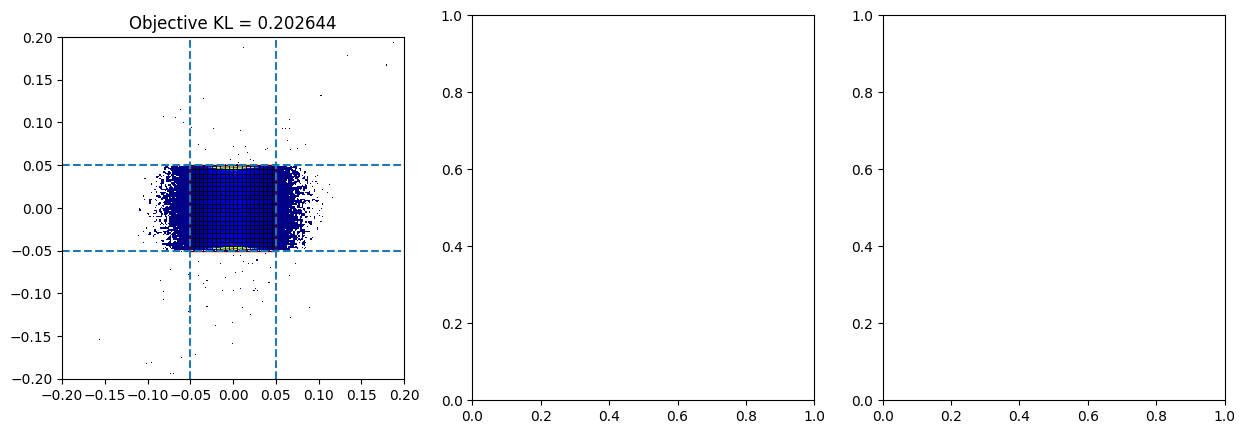

<Figure size 640x480 with 0 Axes>

In [3]:
import xobjects as xo
import xpart as xp
import xcoll as xc
import numpy as np
import xtrack as xt
import pickle
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import *
from madxtools.particles import *
from madxtools.math import *
from cpymad.madx import Madx

from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from pybt.tools.plotters import *
from matplotlib.patches import Ellipse, Rectangle
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from madxtools.plot_tool import *

def calc_initial_condition(E_cin_per_nucleon):
    # E_cin_per_nucleon = 2.0
    # Ion properties
    A = 208.0
    Z = 82.0
    N = 126.0
    charge = 54.0
    m_proton_GeV = 0.93828
    m_neutron_GeV = 0.93957
    m_electron_GeV = 0.000511
    m_u_GeV = 0.9315
    mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
    E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

    p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

    gamma = p/charge/0.938
    beta = np.sqrt(1-gamma**(-2))

    # print(p/charge)
    # print(f"gamma = {round(gamma,3)}")
    # print(f"beta = {round(beta,3)}")
    # print(f"p = {round(p/charge,3)} GeV/c")

    Brho = 3.33564*p/charge

    # Beam characteristics
    exn = 4.92e-06
    eyn = 3.4e-06
    sige = 0.000412
    ex = exn/(beta*gamma)
    ey = eyn/(beta*gamma)

    # Initial conditions
    betx0 = 53.074
    bety0 = 3.675
    alfx0 = -13.191
    alfy0 = 0.859
    Dx0 = 0.13
    Dy0 = 0.0
    Dpx0 = 0.02
    Dpy0 = 0.0
    exn = 2.53e-05
    eyn =  6.94e-06
    sige = 0.00045

    return p, exn, eyn, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, ex, ey, sige

from scipy.stats import pearsonr, spearmanr, kendalltau

# initial_quad_strength = [float(sys.argv[1]),
#                          float(sys.argv[2]),
#                          float(sys.argv[3]),
#                          float(sys.argv[4]),
#                          float(sys.argv[5]),
#                          float(sys.argv[6]),
#                          float(sys.argv[7]),
#                          float(sys.argv[8])]

initial_quad_strength = [-0.28611781,  0.48998671,  0.4186652 , -0.09344907, -0.07466559,
        0.15355204, 29.08274068, 60.83029156]

print(initial_quad_strength[0])
print(initial_quad_strength[1])
print(initial_quad_strength[2])
print(initial_quad_strength[3])
print(initial_quad_strength[4])
print(initial_quad_strength[5])
print(initial_quad_strength[6])
print(initial_quad_strength[7])

num_part = 2*5000
seed = np.random.randint(low=1, high=int(4e9), size=num_part, dtype=np.uint32)

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("simple_seq.seq")

p, exn, eyn, betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, ex, ey, sige = calc_initial_condition(0.5)

madx.input(f'''
beam, particle=PROTON, pc={p};
use, sequence=simple_seq;
''')

madx.input('SEQEDIT, sequence=simple_seq;')
madx.input(f'MOVE, ELEMENT = OCT1, TO={initial_quad_strength[6]};')
madx.input('MOVE, ELEMENT = Q1, TO=1, FROM=OCT1;')
madx.input(f'MOVE, ELEMENT = OCT2, TO={initial_quad_strength[7]};')
madx.input('MOVE, ELEMENT = Q2, TO=1, FROM=OCT2;')
madx.input('ENDEDIT;')
madx.use(sequence="simple_seq")
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

line = xt.Line.from_madx_sequence(
    sequence=madx.sequence.simple_seq,
    allow_thick=True,
    enable_align_errors=True,
    deferred_expressions=True,
)
line.particle_ref = xt.Particles(mass0=xt.PROTON_MASS_EV,
                            gamma0=madx.sequence.simple_seq.beam.gamma)

tw_init = xt.TwissInit(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, dx=dx0, dy=dy0, dpx=dpx0, dpy=dpy0)
tw = line.twiss(method='6d', start="qf1", end="simple_seq$end", init=tw_init)

nemitt_x = exn
nemitt_y = eyn
x_norm, px_norm = xp.generate_2D_gaussian(num_part)
y_norm, py_norm = xp.generate_2D_gaussian(num_part)


def custom_uniformity_score(matrix, x, y, rect_l):
    uniformity_penalty = np.std(matrix)  # Lower is better
    out_of_bounds_penalty = np.sum((x < -rect_l) | (x > rect_l) | (y < -rect_l) | (y > rect_l))
    emptiness_penalty = np.sum(matrix == 0)
    
    # Combine the penalties; adjust weights as necessary
    uniformity_weight = 1.0
    out_of_bounds_weight = 0.01  # Adjust this weight to increase/decrease the penalty for out-of-bounds points
    emptiness_weight = 100.0
    
    # Calculate total score
    score = (uniformity_penalty * uniformity_weight) + \
            (out_of_bounds_penalty * out_of_bounds_weight) + \
            (emptiness_penalty * emptiness_weight)
    return score

def kl_divergence(n_divisions, num_part, counts_matrix):

        number_of_bins = n_divisions**2
        target_per_bin = num_part/number_of_bins # I divide the total number of particles by the number of bins
        P = np.ones((n_divisions, n_divisions))*target_per_bin # I create a square matrix with the correct number of bins
        P = P/P.sum()

        Q = counts_matrix.astype(float)/num_part # This is the matrix where I counted how many particles fall in the bins. The total number of particles inside this region is smaller than num_part.
        Q = np.where(Q==0, np.finfo(float).eps, Q) # Replace any zeros in matrix Q with the smallest positive float number to prevent division by zero errors

        D_KL = np.sum(P * np.log(P / Q)) # Calculate the KL divergence
    
        return D_KL


In [97]:

import scipy.optimize as optimize
import pybobyqa

fetch_rows = lambda indices, attribute: np.array([getattr(twiss.row(index), attribute) for index in indices])

iter = 0
def optimise(params):
    global iter
    print(f"Iteration = {iter}")
    iter+=1
    kQF1, kQD2, kQF3, kQD4, kQ1, kQ2, koct1, koct2 = params
    # print(params)

    p, exn, eyn, betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, ex, ey, sige = calc_initial_condition(0.5)

    # Change and track
    line['qf1'].k1 = kQF1
    line['qd2'].k1 = kQD2
    line['qf3'].k1 = kQF3
    line['qd4'].k1 = kQD4
    line['q1'].k1 = kQ1
    line['q2'].k1 = kQ2
    line['oct1'].knl = [0,0,0,koct1]
    line['oct2'].knl = [0,0,0,koct2]

    # Loop through the tracking
    num_part = 1*5000
    x_norm, px_norm = xp.generate_2D_gaussian(num_part)
    y_norm, py_norm = xp.generate_2D_gaussian(num_part)
    part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                                W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                                nemitt_x=nemitt_x,nemitt_y=nemitt_y)
    # part._init_random_number_generator()
    line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")
    # line_df = line.to_pandas()

    target_s = 100
    s_array = line.record_last_track.s[0]
    differences = np.abs(s_array - target_s)
    s_index = np.argmin(differences)
    x = line.record_last_track.x[:,s_index]
    y = line.record_last_track.y[:,s_index]

    rect_l = 0.05

    # Number of divisions per side
    n_divisions = 20
    side_length = 2* rect_l / n_divisions

    # Initialize an empty list to hold the count of points in each small square
    counts = []
    # Loop over each small square to calculate its bounds and count the points within
    for i in range(n_divisions):
        for j in range(n_divisions):
            # Calculate the bounds of the small square
            x_min = i * side_length - rect_l
            x_max = (i + 1) * side_length - rect_l
            y_min = j * side_length - rect_l
            y_max = (j + 1) * side_length - rect_l
            
            # Count how many points fall within these bounds
            count = np.sum((x >= x_min) & (x < x_max) & (y >= y_min) & (y < y_max))
            counts.append(count)

    # Reshape the counts to match the grid layout for easier interpretation
    counts_matrix = np.reshape(counts, (n_divisions, n_divisions))

    objective =  custom_uniformity_score(counts_matrix, x, y, rect_l)
    # objective = kl_divergence(n_divisions, num_part, counts_matrix)
    
    # print (f"OJECTIVE = {objective}")
    return objective

initial_guess = np.array([initial_quad_strength[0], initial_quad_strength[1], initial_quad_strength[2], initial_quad_strength[3], -0.0, 0.0, 0, 0])

lower = np.array([initial_quad_strength[0] - initial_quad_strength[0]*0.5,
                  initial_quad_strength[1] - initial_quad_strength[1]*0.5,
                  initial_quad_strength[2] - initial_quad_strength[2]*0.5,
                  initial_quad_strength[3] - initial_quad_strength[3]*0.5,
                  -0.5,
                  -0.5,
                  0,
                  0])
upper = np.array([initial_quad_strength[0] + initial_quad_strength[0]*0.5,
                  initial_quad_strength[1] + initial_quad_strength[1]*0.5,
                  initial_quad_strength[2] + initial_quad_strength[2]*0.5,
                  initial_quad_strength[3] + initial_quad_strength[3]*0.5,
                  0.5,
                  0.5,
                  400,
                  400])

soln = pybobyqa.solve(optimise, initial_guess, bounds=(lower,upper), rhobeg = 0.5, rhoend=0.0001, scaling_within_bounds=True, seek_global_minimum=True, objfun_has_noise=True, maxfun=100)
print(soln)

print(soln.x)



Iteration = 0
Iteration = 1
Iteration = 2
Iteration = 3
Iteration = 4
Iteration = 5
Iteration = 6
Iteration = 7
Iteration = 8
Iteration = 9
Iteration = 10
Iteration = 11
Iteration = 12
Iteration = 13
Iteration = 14
Iteration = 15
Iteration = 16
Iteration = 17
Iteration = 18
Iteration = 19
Iteration = 20
Iteration = 21
Iteration = 22
Iteration = 23
Iteration = 24
Iteration = 25
Iteration = 26
Iteration = 27
Iteration = 28
Iteration = 29
Iteration = 30
Iteration = 31
Iteration = 32
Iteration = 33
Iteration = 34
Iteration = 35
Iteration = 36
Iteration = 37
Iteration = 38
Iteration = 39
Iteration = 40
Iteration = 41
Iteration = 42
Iteration = 43
Iteration = 44
Iteration = 45
Iteration = 46
Iteration = 47
Iteration = 48
Iteration = 49
Iteration = 50
Iteration = 51
Iteration = 52
Iteration = 53
Iteration = 54
Iteration = 55
Iteration = 56
Iteration = 57
Iteration = 58
Iteration = 59
Iteration = 60
Iteration = 61
Iteration = 62
Iteration = 63
Iteration = 64
Iteration = 65
Iteration = 66
Itera

Found suitable prebuilt kernel `default_only_xtrack`.


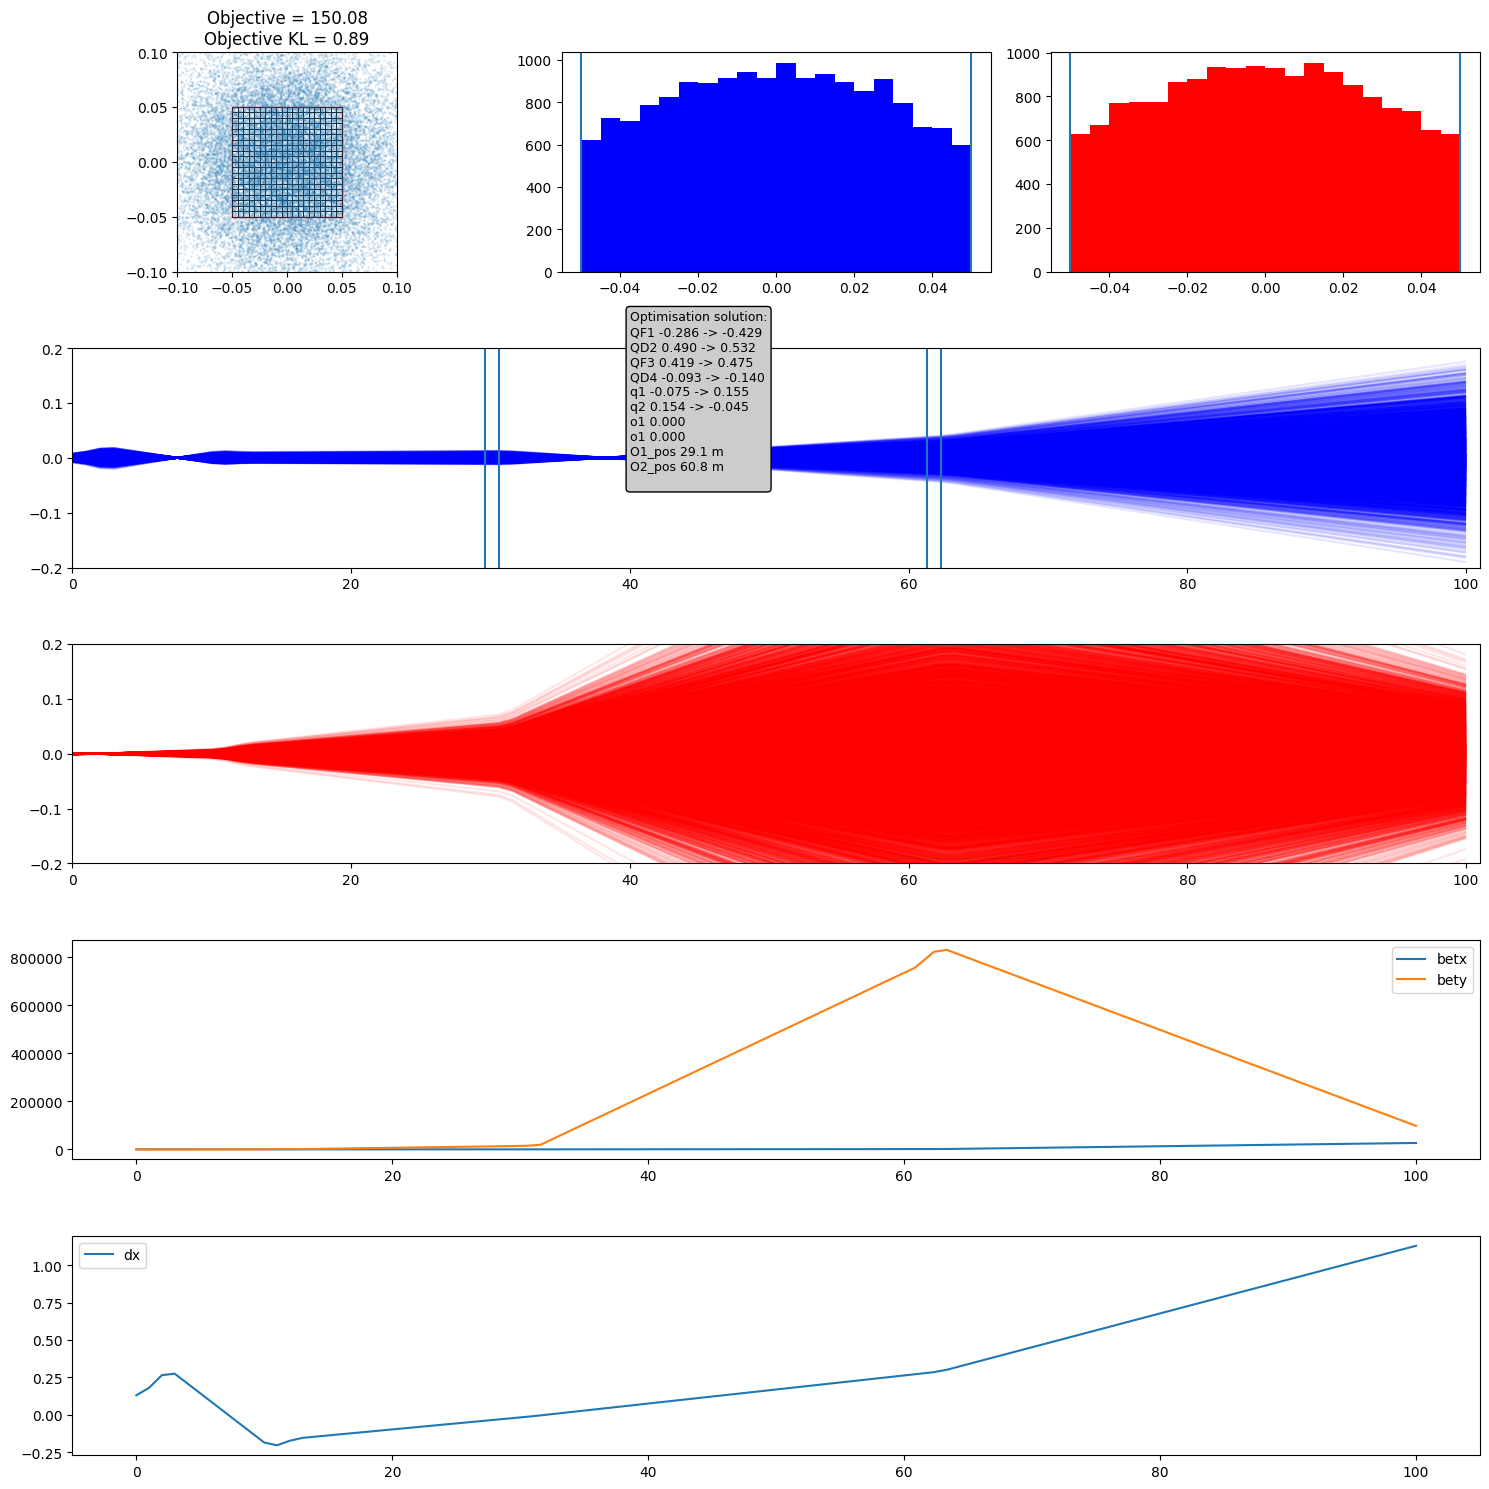

In [98]:
import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap

def using_mpl_scatter_density_with_subplots(fig, ax, x, y):
    # fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'scatter_density'})
    density = ax[0].scatter_density(x, y, cmap=white_jet)
    # fig.colorbar(density, ax=ax[0], label='Number of points per pixel')
    ax[0].set_aspect("equal")
    ax[0].axvline(-rect_l, ls="--")
    ax[0].axvline(rect_l, ls="--")
    ax[0].axhline(-rect_l, ls="--")
    ax[0].axhline(rect_l, ls="--")
    ax[0].set_ylim(-0.2, 0.2)
    ax[0].set_xlim(-0.2, 0.2)
    plt.show()
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)
white_jet = LinearSegmentedColormap.from_list('white_jet', [
    (0, '#ffffff'),    # White at the lowest value
    (1e-20, '#00007F'), # Dark blue just above the lowest value
    (0.35, '#0000FF'),  # Blue
    (0.5, '#7FFF7F'),   # Cyan to Green transition
    (0.65, '#FFFF00'),  # Yellow
    (1, '#7F0000'),    # Dark red at the highest value
], N=256)

# Change and track
line['qf1'].k1 = soln.x[0]
line['qd2'].k1 = soln.x[1]
line['qf3'].k1 = soln.x[2]
line['qd4'].k1 = soln.x[3]
line['q1'].k1 = soln.x[4]
line['q2'].k1 = soln.x[5]
line['oct1'].knl = [0,0,0,soln.x[6]]
line['oct2'].knl = [0,0,0,soln.x[7]]


# Loop through the tracking
num_part = 5*5000
x_norm, px_norm = xp.generate_2D_gaussian(num_part)
y_norm, py_norm = xp.generate_2D_gaussian(num_part)
part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)
# part._init_random_number_generator()
line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")
line_df = line.to_pandas()

mosaic = [
    ['A', 'B', 'C'],
    ['D', 'D', 'D'],
    ['E', 'E', 'E'],
    ['F', 'F', 'F'],
    ['G', 'G', 'G'],
]

fig, ax = plt.subplot_mosaic(mosaic, figsize=(15, 15), tight_layout=True)

target_s = 100
s_array = line.record_last_track.s[0]
differences = np.abs(s_array - target_s)
s_index = np.argmin(differences)
x = line.record_last_track.x[:,s_index]
y = line.record_last_track.y[:,s_index]

rect_l = 0.05
rect = patches.Rectangle((0.0-rect_l, 0.0-rect_l), 2*rect_l, 2*rect_l, linewidth=1, edgecolor='r', facecolor='none')
ax['A'].add_patch(rect)

# Number of divisions per side
n_divisions = 20
side_length = 2 * rect_l / n_divisions

# Loop to create and add small square patches
for i in range(n_divisions):
    for j in range(n_divisions):
        small_rect = patches.Rectangle((i * side_length - rect_l, j * side_length - rect_l), side_length, side_length, linewidth=0.5, edgecolor='k', facecolor='none')
        ax['A'].add_patch(small_rect)

# Initialize an empty list to hold the count of points in each small square
counts = []

# Loop over each small square to calculate its bounds and count the points within
for i in range(n_divisions):
    for j in range(n_divisions):
        # Calculate the bounds of the small square
        x_min = i * side_length - rect_l
        x_max = (i + 1) * side_length - rect_l
        y_min = j * side_length - rect_l
        y_max = (j + 1) * side_length - rect_l
        
        # Count how many points fall within these bounds
        count = np.sum((x >= x_min) & (x < x_max) & (y >= y_min) & (y < y_max))
        counts.append(count)

# Reshape the counts to match the grid layout for easier interpretation
counts_matrix = np.reshape(counts, (n_divisions, n_divisions))

objective =  custom_uniformity_score(counts_matrix, x, y, rect_l)
objective_kl = kl_divergence(n_divisions,num_part, counts_matrix)
ax['A'].set_title(f"Objective = {objective:.2f}\nObjective KL = {objective_kl:.2f}")

# using_mpl_scatter_density_with_subplots(fig, ax, x, y)
ax['A'].scatter(x,y,s=1, alpha=0.1)
ax['B'].hist(x,bins=n_divisions, range=(-rect_l,rect_l), color="b");
ax['C'].hist(y,bins=n_divisions, range=(-rect_l,rect_l), color="r");

ax['B'].axvline(-rect_l)
ax['B'].axvline(rect_l)
ax['C'].axvline(-rect_l)
ax['C'].axvline(rect_l)

ax['A'].set_ylim(-0.1, 0.1)
ax['A'].set_xlim(-0.1, 0.1)
ax['A'].set_aspect("equal")



##################
### BEAM SIZE ####
##################

from matplotlib.collections import LineCollection

# Change and track
line['qf1'].k1 = soln.x[0]
line['qd2'].k1 = soln.x[1]
line['qf3'].k1 = soln.x[2]
line['qd4'].k1 = soln.x[3]
line['q1'].k1 = soln.x[4]
line['q2'].k1 = soln.x[5]
line['oct1'].knl = [0,0,0,soln.x[6]]
line['oct2'].knl = [0,0,0,soln.x[7]]


# Loop through the tracking
num_part = 1*5000
x_norm, px_norm = xp.generate_2D_gaussian(num_part)
y_norm, py_norm = xp.generate_2D_gaussian(num_part)
part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)

line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")
line_df = line.to_pandas()

lines = [list(zip(line.record_last_track.s[i], line.record_last_track.x[i])) for i in range(len(line.record_last_track.s))]
line_collection = LineCollection(lines, colors='blue', alpha=0.1)
ax['D'].add_collection(line_collection)
ax['D'].set_ylim(-0.2, 0.2)
ax['D'].set_xlim(0, 101)

lines = [list(zip(line.record_last_track.s[i], line.record_last_track.y[i])) for i in range(len(line.record_last_track.s))]
line_collection = LineCollection(lines, colors='red', alpha=0.1)
ax['E'].add_collection(line_collection)
ax['E'].set_ylim(-0.2, 0.2)
ax['E'].set_xlim(0, 101)

ax['D'].axvline(line_df[line_df.name == 'oct1'].s.iloc[0])
ax['D'].axvline(line_df[line_df.name == 'q1'].s.iloc[0])
ax['D'].axvline(line_df[line_df.name == 'oct2'].s.iloc[0])
ax['D'].axvline(line_df[line_df.name == 'q2'].s.iloc[0])

ax['D'].annotate(
    (f'Optimisation solution:\n'
    f'QF1 {initial_quad_strength[0]:.3f} -> {soln.x[0]:.3f}\n'
    f'QD2 {initial_quad_strength[1]:.3f} -> {soln.x[1]:.3f}\n'
    f'QF3 {initial_quad_strength[2]:.3f} -> {soln.x[2]:.3f}\n'
    f'QD4 {initial_quad_strength[3]:.3f} -> {soln.x[3]:.3f}\n'
    f'q1 {initial_quad_strength[4]:.3f} -> {soln.x[4]:.3f}\n'
    f'q2 {initial_quad_strength[5]:.3f} -> {soln.x[5]:.3f}\n'
    f'o1 {soln.x[6]:.3f}\n'
    f'o1 {soln.x[7]:.3f}\n'
    f'O1_pos {initial_quad_strength[6]:.1f} m\n'
    f'O2_pos {initial_quad_strength[7]:.1f} m\n'
    ),
    xy=(40.0, -0.05), xycoords='data',
    xytext=(0, 0), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.8"), fontsize=9)

tw_init = xt.TwissInit(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, dx=dx0, dy=dy0, dpx=dpx0, dpy=dpy0)
tw = line.twiss(method='6d', start="qf1", end="simple_seq$end", init=tw_init)
ax["F"].plot(tw.s, tw.betx,label="betx")
ax["F"].plot(tw.s, tw.bety, label="bety")
ax["G"].plot(tw.s, tw.dx, label="dx")
ax["F"].legend()
ax["G"].legend()

plt.savefig("end_of_line.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')